# **Lab 4.1 Data Augmentation with PyTorch**

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os
from PIL import Image 

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [2]:
# transform_resize = transforms.Resize((224, 224))
# transform_tensor = transforms.ToTensor()
# transform_pad = transforms.Pad(10)
# transform_affine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45)
# transform_crop = transforms.CenterCrop(200)

# def transform_image(image):
#     image = transform_resize(image)
#     image = transform_tensor(image)
#     image = transform_pad(image)
#     image = transform_affine(image)
#     image = transform_crop(image)
#     return image

def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Pad(10),  # Padding of 10 pixels
        transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45),
        transforms.CenterCrop(200)  # Crop to 200x200 after random affine
    ])

    dataset = ImageFolder(root=path, transform=transform)

    # dataset = ImageFolder(root=path, transform=transform_image)

    # Printing the class labels and number of images in each class
    print("📃Train Dataset:")
    for idx, class_name in enumerate(dataset.classes):
        class_size = len([img for img, label in dataset if label == idx])
        print(f"Number of images in class {class_name}: {class_size}")
    
    print(f"Number of samples: {len(dataset)}")

    # Create DataLoader
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    ### END CODE HERE ###

    return data_loader

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

📃Train Dataset:
Number of images in class battleship: 44
Number of images in class patrol boat: 35
Number of images in class submarine: 35
Number of samples: 114


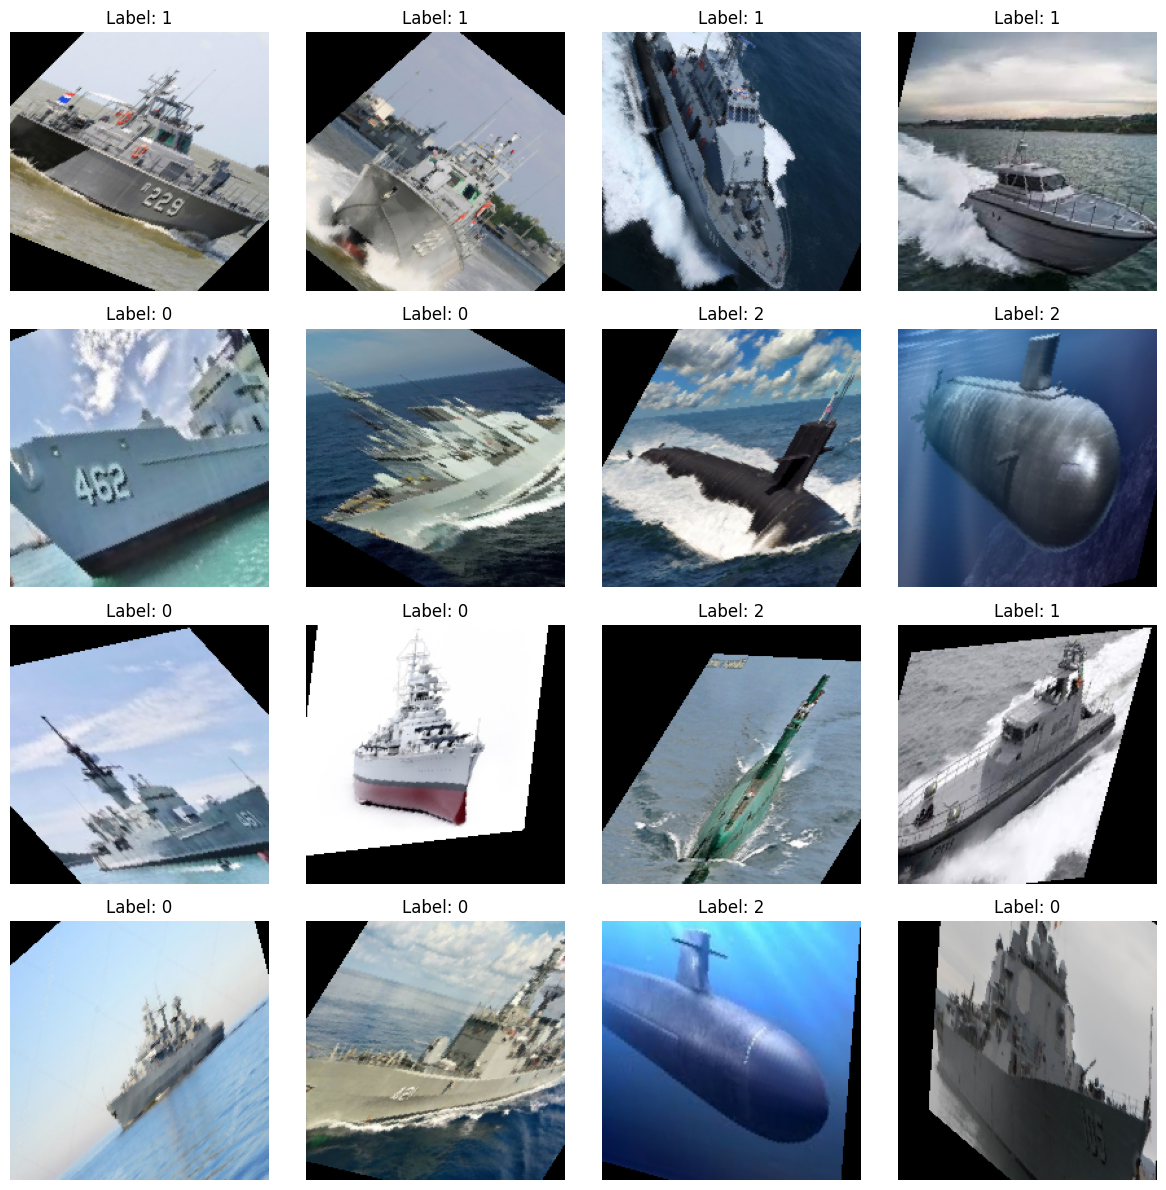

In [3]:
# Example usage:
# Assuming the dataset is in the "data/train" folder
data_loader = load_data('./Ship/Ship/Train')

# Displaying the first 16 images from the first batch (4x4 grid)
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust the layout so the images don't overlap
plt.show()

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [23]:
from PIL import ImageFilter

class CustomImageDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.transform_resize = transforms.Resize((224, 224))
        self.transform_tensor = transforms.ToTensor()
        self.transform_pad = transforms.Pad(10)
        self.transform_affine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45)
        self.transform_crop = transforms.CenterCrop(200)

    def __getitem__(self, idx):
        image = None
        label = None
        return image, label
    
    def transform_image(self, image):
        # Apply Resize
        image = self.transform_resize(image)
        # Apply Gaussian Blur
        image = image.filter(ImageFilter.GaussianBlur(radius=2)) # add_gaussian_blur()
        # Convert image to tensor
        image = self.transform_tensor(image)
        # Apply Padding
        image = self.transform_pad(image)
        # Apply Affine Transformation
        image = self.transform_affine(image)
        # Apply Center Crop
        image = self.transform_crop(image)
        # Add Gaussian Noise
        image = self.add_gaussian_noise(image)
        return image
    
    def add_gaussian_noise(self, image, mean=0., std=0.08):
        """Function to add Gaussian noise to an image tensor."""
        noise = torch.randn_like(image) * std + mean
        return image + noise

    def load_data(self):
        # Compose Dataset with transformations
        dataset = ImageFolder(root=self.path, transform=self.transform_image)
        
        print("📃 Train Dataset:")
        for idx, class_name in enumerate(dataset.classes):
            class_size = len([img for img, label in dataset if label == idx])
            print(f"Number of images in class {class_name}: {class_size}")
        
        print(f"Number of samples: {len(dataset)}")

        data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

        return data_loader


Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

📃 Train Dataset:
Number of images in class battleship: 44
Number of images in class patrol boat: 35
Number of images in class submarine: 35
Number of samples: 114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3111308..1.2472053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30004722..1.2396199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36762387..0.9904917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28870666..1.2175221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24049175..1.1343858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28328988..1.1577111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2

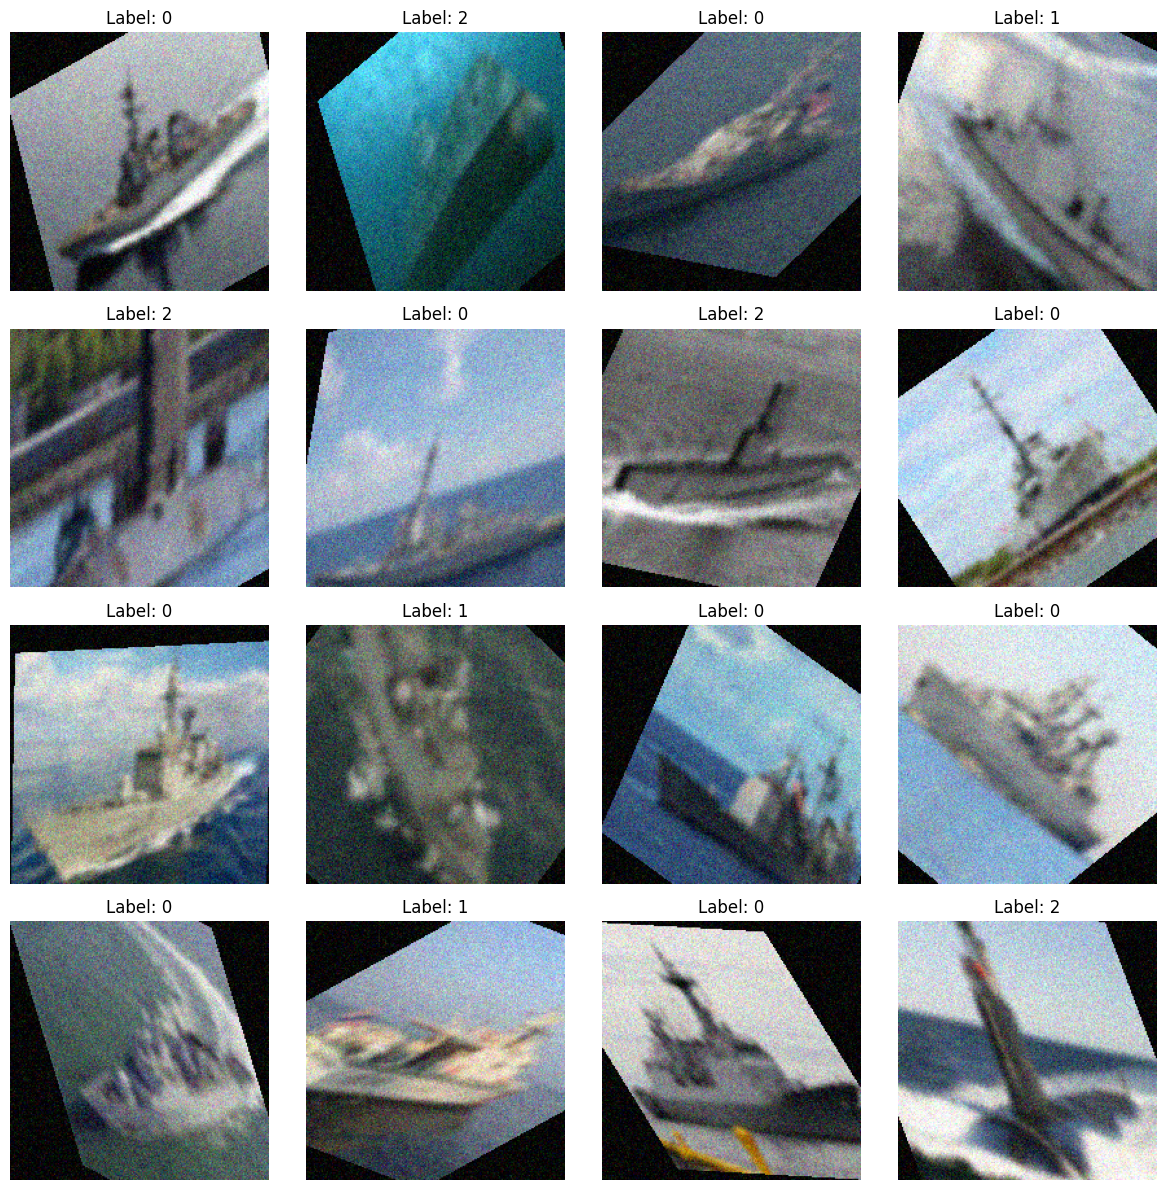

In [24]:
### START CODE HERE ###

dataset = CustomImageDataset('./Ship/Ship/Train')
# dataloader = DataLoader(None)
data_loader = dataset.load_data()

data_iter = iter(data_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

Ans
1. คือการเติมสีที่ขอบของรูปภาพเมื่อมันถูกยืดหรือปรับขนาดให้พอดี ข้อดีของมันคือทำให้รูปภาพที่เปลี่ยนขนาดออกมาไม่เสียรายละเอียดมากเกินไป โดยสามารถเลือกเติมสีเป็นสีดำ หรือสีอื่น ๆ ก็ได้ ซึ่งช่วยให้ภาพยังคงดูสมบูรณ์
2. การใช้การเพิ่มรูปภาพ (augmentation) ควรทำในปริมาณที่พอดี เช่น การหมุนรูป หรือการเปลี่ยนแปลงแสงนิดหน่อย ไม่ควรทำมากเกินไป เพราะอาจทำให้คอมพิวเตอร์สับสนเวลาเรียนรู้
3. ใส่จุดดำและขาวเข้าไปในรูปภาพ ซึ่งทำให้ภาพดูมีความผิดปกติ เช่น บางจุดจะเป็นจุดสีขาวหรือดำที่ไม่ปกติ วิธีการทำให้เกิดคือการสุ่มเลือกจุดในรูปภาพแล้วเปลี่ยนสีของมันให้เป็นสีดำหรือขาว
4. ถ้าอยากจำลองเอฟเฟกต์ของเลนส์กล้อง เช่น ภาพที่เบลอที่ขอบ การใช้คำสั่งที่เรียกว่า "affine transformation" หรือ "lens distortion" จะช่วยให้ภาพมีลักษณะเหมือนผ่านเลนส์กล้องได้